In [1]:
# %load D:/BUDS_MID/__init__.py
"""
Created on Wed Feb 19 16:21:00 2020

@author: cmchico

usual imports
"""

import os
import pandas as pd
import numpy as np

pd.options.display.max_rows = 100
pd.set_option('display.float_format', '{:.0f}'.format)

from time import time
from datetime import timedelta

import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
atm_profile = pd.read_excel('D:/BUDS_MID/OJT ATM/ATM Forecasting Data/Actual/ATM Profile.xlsx')
atm_profile = atm_profile[atm_profile.TYPE=='ATM'][['TID','Branch Code Orig']].copy()
atm_profile.columns=['TID','BRCODE']

In [3]:
atm_profile.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2419 entries, 0 to 2972
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TID     2419 non-null   int64 
 1   BRCODE  2419 non-null   object
dtypes: int64(1), object(1)
memory usage: 56.7+ KB


In [6]:
df = pd.read_pickle('D:/BUDS_MID/OJT ATM/ATM Forecasting Data New/Actual/81 W Data Filter Impute G4S.pkl')
df = df.merge(atm_profile, how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3150778 entries, 0 to 3150777
Data columns (total 22 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   DATE                      datetime64[ns]
 1   TID                       int64         
 2   WDL_AMT_OFFUS             float64       
 3   WDL_AMT_ONUS              float64       
 4   WDL_COUNT_OFFUS           float64       
 5   WDL_COUNT_ONUS            float64       
 6   WDL_AMT                   float64       
 7   WDL_COUNT                 float64       
 8   file                      object        
 9   filter_                   object        
 10  t_duration_hr             float64       
 11  WDL_AMT_STD_YR            float64       
 12  DAY                       object        
 13  WDL_AMT_IMPUTE            float64       
 14  WDL_AMT_OFFUS_IMPUTE      float64       
 15  WDL_AMT_STD_DAY_YR        float64       
 16  WDL_AMT_OFFUS_STD_DAY_YR  float64       
 17  G4S_2019

In [7]:
select = df.BRCODE.isnull()
df.loc[select,'filter_'] = 'Not in 2019 Profile'

In [8]:
df.BRCODE = df.BRCODE.fillna("OFF")
df['TID_BR'] = df.BRCODE.str.upper().str.replace(" ","")
select = df.BRCODE.str.upper().str.contains('OFF')
df.loc[select,'TID_BR'] = df.loc[select,'TID'].astype(str)

In [9]:
df['TID_BR_filter'] = df.filter_

In [10]:
for a in df.filter_.unique():
    a='LT90% available week'
    tid = df[df.filter_ == a].TID.unique()
    tid_br = df[df.TID.isin(tid)].TID_BR.unique()
    select = df.TID_BR.isin(tid_br)
    df.loc[select,'TID_BR_filter'] = a

In [11]:
#DATA WATERFALL
df[df.WDL_AMT>0].pivot_table(index=['G4S_2019','TID_BR_filter'], columns=['YEAR'],values=['TID_BR'], aggfunc=pd.Series.nunique)

TID_BR               
YEAR                                 2017 2018 2019 2020
G4S_2019 TID_BR_filter                                  
NO                                    503  503  503  500
         Changed availability week     27   27   27   24
         LT90% available week         220  220  275  228
         Not in 2019 Profile          182   78   51   55
YES                                   658  658  658  650
         Changed availability week     53   53   53   51
         LT90% available week         264  264  365  312
         Not in 2019 Profile           12   12  101   83

In [12]:
#DATA WATERFALL
df[df.WDL_AMT>0].pivot_table(index=['G4S_2019','filter_'], columns=['YEAR'],values=['TID'], aggfunc=pd.Series.nunique)

TID               
YEAR                               2017 2018 2019 2020
G4S_2019 filter_                                      
NO                                  707  707  707  699
         Changed availability week   32   32   32   29
         LT90% available week       230  230  295  220
         Not in 2019 Profile        182   78   51   55
YES                                 905  905  905  890
         Changed availability week   63   63   63   61
         LT90% available week       294  294  417  279
         Not in 2019 Profile         12   12  101   83

### For Modeling

In [20]:
data = df[(df.TID_BR_filter=="") & (df.G4S_2019 == "YES")][['DATE','TID','WDL_AMT','WDL_AMT_FIN']].copy()

In [21]:
data_br = df[(df.TID_BR_filter=="") & (df.G4S_2019 == "YES")].groupby(['DATE','TID_BR']) \
                [['WDL_AMT','WDL_AMT_FIN']].sum().reset_index()

In [22]:
data_br

,DATE,TID_BR,WDL_AMT,WDL_AMT_FIN
0,2017-01-01,91010033,0,0
1,2017-01-01,91010053,0,0
2,2017-01-01,91010068,0,0
3,2017-01-01,91010075,0,0
4,2017-01-01,91010090,0,0
...,...,...,...,...
751431,2020-02-16,BR987,352900,352900
751432,2020-02-16,BR988,1104500,1104500
751433,2020-02-16,BR992,2084900,2084900
751434,2020-02-16,BR996,5312300,5312300


In [23]:
data

,DATE,TID,WDL_AMT,WDL_AMT_FIN
5710,2017-01-01,91010018,621300,621300
5711,2017-01-02,91010018,42700,42700
5712,2017-01-03,91010018,21800,21800
5713,2017-01-04,91010018,0,0
5714,2017-01-05,91010018,2042900,2042900
...,...,...,...,...
2576347,2020-02-12,91016725,1419300,1419300
2576348,2020-02-13,91016725,2284700,2284700
2576349,2020-02-14,91016725,3027400,3027400
2576350,2020-02-15,91016725,2923300,2923300


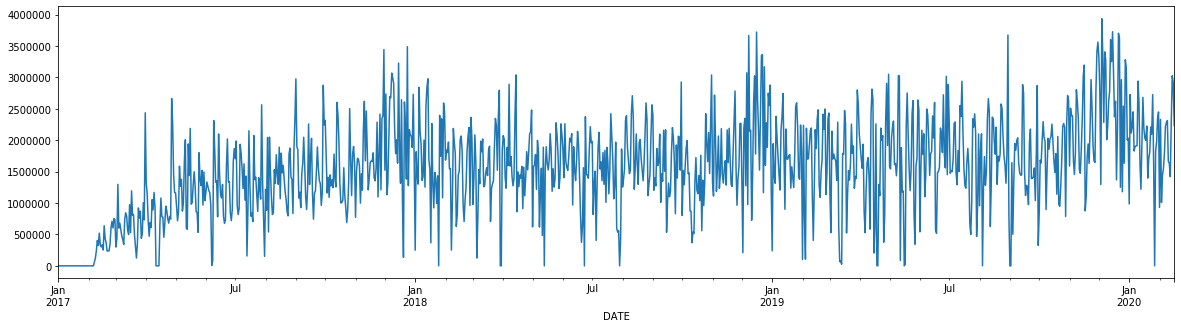

In [26]:
data[data.TID==91016725].set_index('DATE').WDL_AMT_FIN.plot(figsize=(20,5))

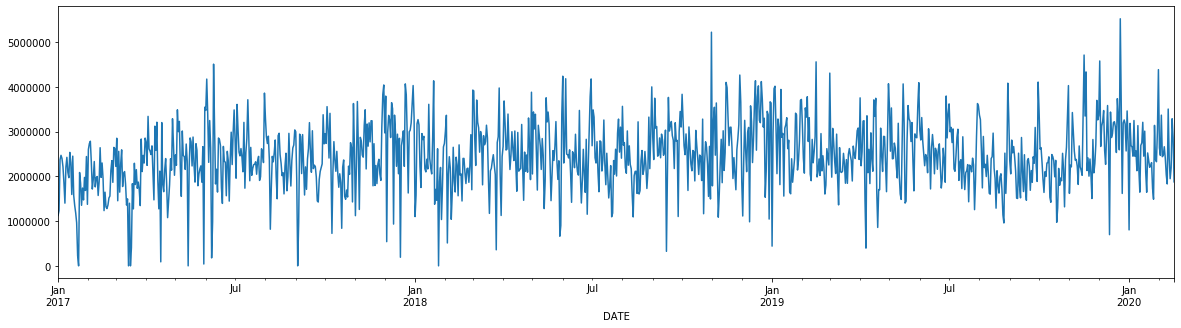

In [28]:
data_br[data_br.TID_BR=='BR054'].set_index('DATE').WDL_AMT_FIN.plot(figsize=(20,5))

In [29]:
data_br.to_pickle('82 Aggregated TIDBR WDL.pkl')
data.to_pickle('82 Aggregated TID WDL.pkl')